# Analemma Plots

This notebook uses the results from [Sundial Calculations](sundial.md) as encoded in the [analemma package](index.md) to visualize various properties of sundials, in particular analemmas.

In [1]:
from analemma import orbit, plot as aplot
import matplotlib.pyplot as plt
import numpy as np

pi = np.pi
earth = orbit.PlanetParameters.earth()
camdial = aplot.DialParameters(theta=37.5/180*pi, iota=37.5/180*pi, i=0, d=0) # Analemmatic dial in Cambridge, UK

## Sunrise and Sunset

We will need to know the range of time within each day to plot the path of the tip of the shadow as the sun moves through the sky. This is determined by the angle between the sun ray and the face of the dial. When the sun ray and dial face are parallel, we have an effective sunrise or sunset relative to the dial. When the sun ray is closest to perpendicular to the dial face, we have an effective noon relative to the dial. For some dials on some days, such points do not exist and there is either a shadow throughout the entire day or the lack thereof.

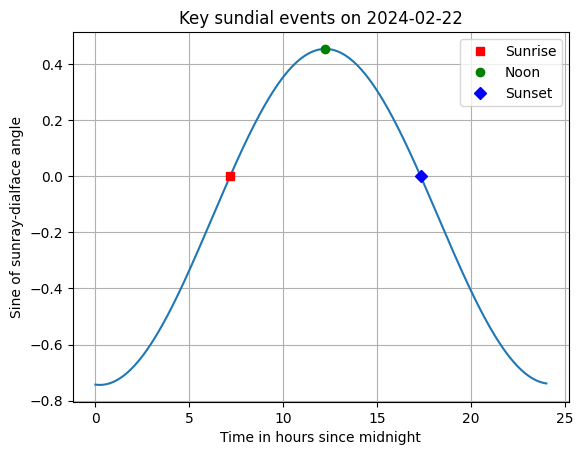

In [2]:
days_since_perihelion = 50
st = aplot.find_sun_rise_noon_set_relative_to_dial_face(days_since_perihelion, earth, camdial)

times = st.sample_times_for_one_day()
abs_seconds = np.array([st.absolute_seconds for st in times])
sines = aplot.sin_sunray_dialface_angle(abs_seconds, earth, camdial)

fig, ax = plt.subplots()
ax.plot([st.hours_from_midnight for st in times], sines)
ax.plot(st.sunrise.hours_from_midnight, aplot.sin_sunray_dialface_angle(st.sunrise.absolute_seconds, earth, camdial), 'sr', label="Sunrise")
ax.plot(st.noon.hours_from_midnight,    aplot.sin_sunray_dialface_angle(st.noon.absolute_seconds, earth, camdial), 'og', label="Noon")
ax.plot(st.sunset.hours_from_midnight,  aplot.sin_sunray_dialface_angle(st.sunset.absolute_seconds, earth, camdial), 'Db', label="Sunset")
ax.grid()
ax.set_xlabel("Time in hours since midnight")
ax.set_ylabel("Sine of sunray-dialface angle")
ax.set_title(f"Key sundial events on {aplot.orbit_day_to_date(days_since_perihelion)}")
ax.legend()

## The Solstices

The June and December solstices should occur on the longest and shortest day of the year for the given dial.

In [3]:
import datetime

sun_times = [aplot.find_sun_rise_noon_set_relative_to_dial_face(days_since_perihelion, earth, camdial) for days_since_perihelion in np.arange(0, 365)]

day_lengths = [st.sunset.hours_from_midnight - st.sunrise.hours_from_midnight for st in sun_times]
december_solstice = np.argmin(day_lengths)
june_solstice = np.argmax(day_lengths)

assert aplot.orbit_day_to_date(0) == datetime.date.fromisoformat("2024-01-03")
assert aplot.orbit_day_to_date(june_solstice) == datetime.date.fromisoformat("2024-06-21")
assert aplot.orbit_day_to_date(december_solstice) == datetime.date.fromisoformat("2024-12-21")

assert aplot.orbit_date_to_day(datetime.date.fromisoformat("2024-01-03")) == 0
assert aplot.orbit_date_to_day(datetime.date.fromisoformat("2024-06-21")) == june_solstice
assert aplot.orbit_date_to_day(datetime.date.fromisoformat("2024-12-21")) == december_solstice

arbitrary_date = datetime.date.fromisoformat("2024-05-26")
assert aplot.orbit_day_to_date(aplot.orbit_date_to_day(arbitrary_date)) == arbitrary_date


## Daytime

An effective daytime relative to the dial exists when the sine of the sunray-dialface angle is positive.

Text(0.5, 0.98, 'Daytime throughout the year')

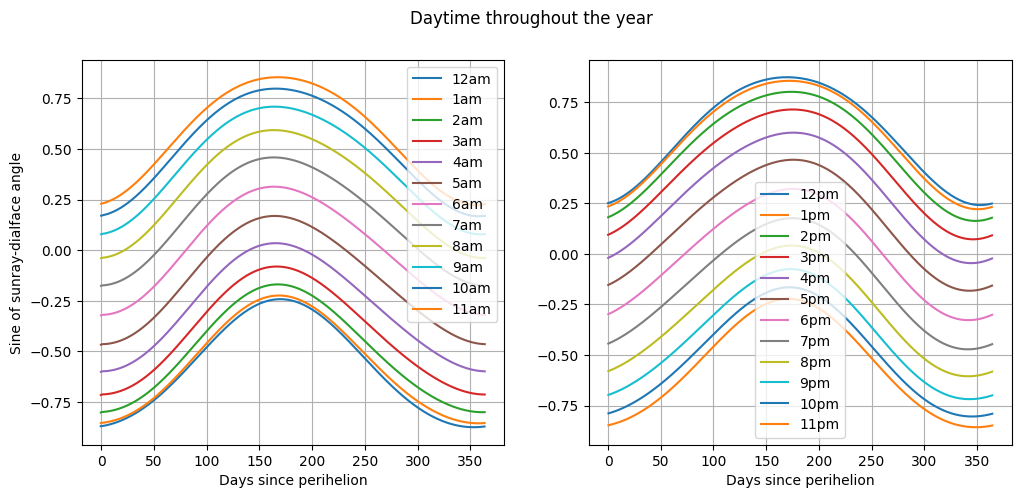

In [4]:
def _plot_sunray_dialface_angle(ax, begin_hour, end_hour, planet : orbit.PlanetParameters, dial : aplot.DialParameters):
    for hour_offset in np.arange(begin_hour, end_hour):
        times, sines = aplot.sunray_dialface_angle_over_one_year(planet, dial, hour_offset)
        ax.plot(times/3600/24, sines, label=aplot.hour_offset_to_oclock(hour_offset))
    ax.grid()
    ax.legend()
    ax.set_xlabel("Days since perihelion")


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

_plot_sunray_dialface_angle(ax[0], -12, 0, earth, camdial)
ax[0].set_ylabel("Sine of sunray-dialface angle")
_plot_sunray_dialface_angle(ax[1], 0, 12, earth, camdial)

fig.suptitle("Daytime throughout the year")


## Analemmas

The analemma is the path traced by the sun in the sky, or the shadow on a sundial, throughout one year when viewed at the same time each day, and typically has a figure-of-eight shape, because of the [equation of time](equation_of_time.md).

In the plots below we show several analemmas, one per hour of daytime. The line style shows the season. One line showing the path of the shadow tip during the day for each solstice is also shown (with line style appropriate to the season) and forms an envelope marking the longest shadows in Winter and the shortest shadows in Summer. Similarly, the path of the shadow tip on each equinox is shown and appears as a straight line. Moreover, the two straight lines fall on top of each other.

A black circle marks the base of the gnomon, which has unit length.

Text(0.5, 1.0, 'Analemmatic sundial in Cambridge, UK')

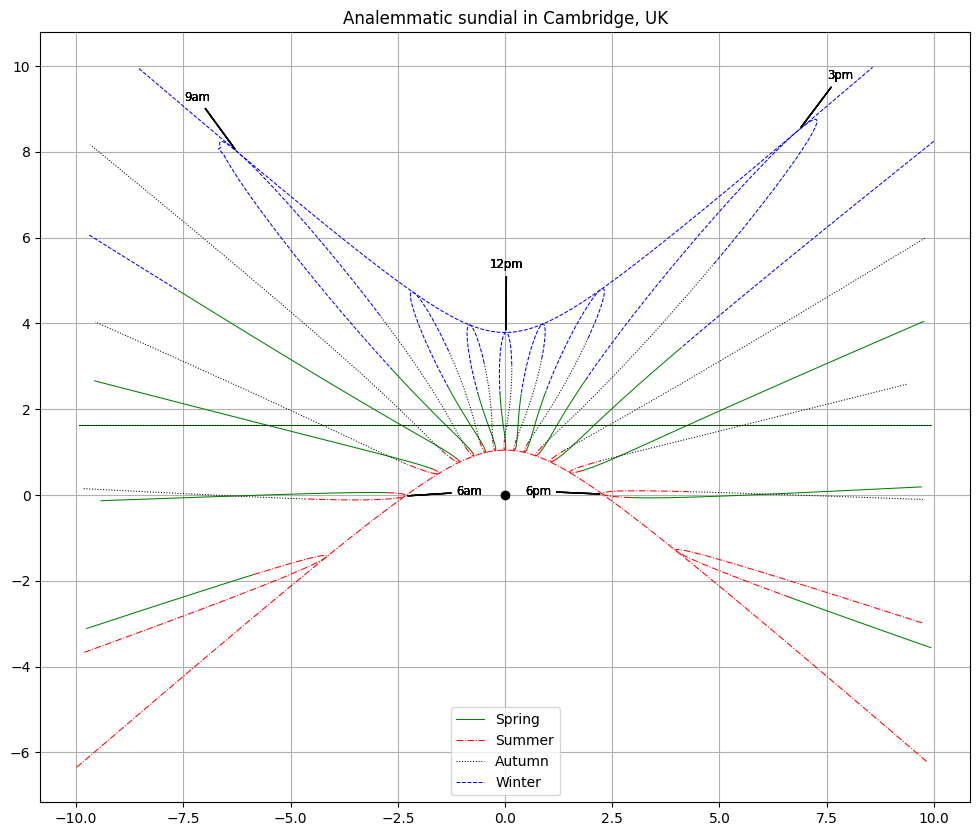

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.grid()
ax.axis("equal")

hour_offsets = aplot.find_daytime_offsets(earth, camdial)

lines_for_legend = []
for season in aplot.Season:
    for hour in hour_offsets:
        aplot.plot_analemma_season_segment(ax, season, hour, earth, camdial, linewidth=0.75)
        aplot.annotate_analemma_with_hour(ax, hour, earth, camdial)
    lines_for_legend += aplot.plot_special_sun_path(ax, season, earth, camdial, linewidth=0.75)

# put a circle at the base of the gnomon
ax.plot( 0, 0, 'ok' )

ordered_lines = [lines_for_legend[season.value] for season in [aplot.Season.Spring, aplot.Season.Summer, aplot.Season.Autumn, aplot.Season.Winter]]
ax.legend(handles=ordered_lines)

ax.set_title("Analemmatic sundial in Cambridge, UK")